# Women's ICC T20 World Cup data visualisation (ball by ball)
In this notebook we look at the 5 most recent Women's T20 World Cups (2014, 2016, 2018, 2020 and 2023), and create some graphs to help visualise the results from the matches, ball by ball. Each tournament tends to be looked at indivdually, allowing for comparisons between years. Unfortunately a handful of matches (primarily from 2014) were missing from the original source of data, and so any statistics calculated may be slightly off the true value, but the general idea should still be reflected. Any feedback would be appreciated :) 

The csv files used can be found at : https://www.kaggle.com/datasets/acidbear55/icc-womens-t20-world-cups-2014-2023/data

Original json files/stats taken from https://cricsheet.org/downloads/

In [162]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SyntaxWarning)
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [163]:
# Constants used throughout
COUNTRY_INFO = {
    "Australia" : ("xkcd:canary yellow", "AUS"),
    "Bangladesh" : ("xkcd:pine","BNG"),
    "England": ("xkcd:bright red","ENG"),
    "India": ("xkcd:royal blue", "IND"),
    "Ireland" : ("xkcd:bright green","IRL"),
    "New Zealand": ("xkcd:slate grey", "NZL"),
    "Pakistan" : ("xkcd:emerald", "PAK"),
    "Thailand" : ("xkcd:bright sky blue", "THA"),
    "South Africa" : ("xkcd:yellow/green", "RSA"),
    "Sri Lanka" : ("xkcd:mid blue", "SRI"),
    "West Indies" : ("xkcd:maroon","WIN"), }
DEFAULT_COLOURS = sns.color_palette("bright")
YEARS = ["2014","2016","2018","2020","2023"]
NAME_CHANGES = { "NR Sciver": "NR Sciver-Brunt",
                 "KH Brunt" : "KH Sciver-Brunt",}

def namecheck(player):
    """ Replaces a players name with their new one in a df """
    try: return NAME_CHANGES[player]
    except KeyError: return player 

In [164]:
# Read in data, and replace players name with the updated version
raw_data = pd.read_csv("..\csv files\Ball_by_Ball_Data.csv")
raw_data = raw_data.map(namecheck)
player_data = pd.read_csv("..\csv files\WCPlayersList.csv")
player_data = player_data.map(namecheck)
for col in player_data.columns:
    player_data.loc[player_data[col].duplicated(),col] = np.NaN

WICKET_ADDITIONS = pd.read_csv("..\csv files\WICKET_ADDITIONS.csv")
RUN_ADDITIONS = pd.read_csv("..\csv files\RUN_ADDITIONS.csv")

In [165]:
def find_nationality(player):
    """Returns the nationality of a given player (to be used with COUNTRY_INFO)"""
    for k in player_data.columns:
        if player in player_data[k].values:
            return k

# Dismissals

Firstly we can see the distribution of how players have been dismissed in each edition of the tournament. Everything has stayed fairly consistent over the years, although the number of lbws and run outs seemed to have decreased in the more recent tournaments. The number of players out from catches has only increased through the years, but with caught and bowled dismissals tending to decrease. Very rarely a player has had to retired hurt (although this doesn't tend to count as 'out' for overall records.)

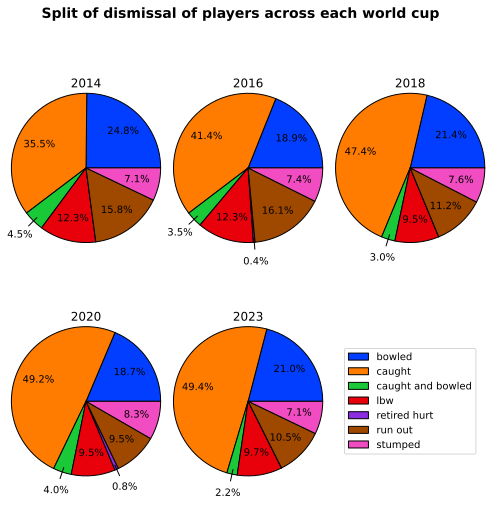

In [166]:
# comparison of methods of players getting out 

# basic setup of data for this piechart
piechart_data = raw_data[['season','dismissal']].copy()
years = [x for _,x in piechart_data.groupby(piechart_data['season'])]
all_methods = piechart_data['dismissal'].value_counts().sort_index().index.tolist()

# ensures every year has all methods in (so any that are missing are added 
# in with a value of 0) 
percents = []
for idx,year in enumerate(years):
    percs = (year['dismissal'].value_counts().sort_index().tolist())
    labels = (year['dismissal'].value_counts().sort_index().index.tolist())
    missing = set(all_methods) - set(labels)
    comb = list(zip(labels,percs)) + [(x,0) for x in missing]
    all_labs, all_percents = zip(*(sorted(comb)))
    percents.append(all_percents)

# makes pie charts for each year (doesn't show percents that are 0)
fig1, axes1 = plt.subplots(2,3,figsize=(8.5,8.5))
axes1 = axes1.ravel()

for idx,ax in enumerate(axes1[:-1]):
    (for_legend,_,texts) =ax.pie(x=percents[idx],colors=DEFAULT_COLOURS,
                            autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '',
                            wedgeprops={'edgecolor' : 'black'},
                            textprops={'fontsize' : 10},radius = 1.25,
                            pctdistance = 0.7)
    ax.set_title(YEARS[idx])

    for text in texts:
        try: 
            if float(text.get_text()[:-1]) < 5:
                (x,y) = text.get_position()
                text.set_position((x*1.8,y*1.8))
                axes1[idx].annotate('', xy=(x*1.3, y*1.3), xytext=(x*1.6, y*1.6),
                                    arrowprops=dict(arrowstyle='-'))
        except ValueError: pass

# figure and legend setup
axes1[-1].set_axis_off()
axes1[-1].legend(for_legend,all_methods,loc='center',fontsize=10)
fig1.suptitle("Split of dismissal of players across each world cup",
              fontsize=14,fontweight='bold')
fig1.subplots_adjust(bottom=0.164,top=0.888,wspace=0.086,hspace=0.117)

# Individual player stats

We can see a small group of Australian players who have been around for a long time (Lanning, Healy, Mooney, Schutt and Perry) having quite remarkable stats, and topping all metrics. Nat Sciver-Brunt is the only player who has managed to make it on the chart for both most runs scored and most wickets taken. It's interesting to see that in all these graphs, there is quite a wide spread of nationalities. 

NOTE : For total runs scored and wickets taken, I have added in the missing stats from the games which I am aware are missing (the 2nd, 6th, 9th and 11th matches of the 2014 WC), so these should be as close to the true value as possible. These are the ONLY graphs which have been altered to include data from these missing games. 

In [167]:
def make_bar_chart(ax,series,y_label,col_name):
    """Creates a bar chart from a series"""
    players, values = series.index.to_list(), series[col_name].to_list()
    labels = [f"{player}\n({int(score)})" 
              for (player,score) in zip(players,values)]
    colours = [COUNTRY_INFO[find_nationality(x)][0] for x in players]

    rects = ax.bar(2*np.arange(len(labels)), values ,1.2,
                   color=colours,edgecolor='black')
    ax.bar_label(rects, labels=labels, padding=3,rotation=10)

    ax.set_ylabel(y_label)
    ax.set_xticks([])
    ax.spines[['right', 'top']].set_visible(False)

In [168]:
# top run scorers and wicket takers over all WCs 
top_run_wicket_data = raw_data[['season','batter','bowler','runs_off_bat',
                                'player_out','dismissal','non_boundary',
                                'extras_off_ball']].copy()
top_run_wicket_data['valid wicket'] = ~((top_run_wicket_data['player_out'].isnull())
         | (top_run_wicket_data['dismissal'].isin(['run out','retired hurt'])))

def get_top_wicks_and_runs(ax,val):
    """Adds in additions from missed games, then takes the 8 largest values in 
    each category makes the bar chart with them"""
    if val == 'runs':
        position, col = 'batter', 'runs_off_bat',
        additions, y_lab = RUN_ADDITIONS , "Number of Runs"
    else: 
        position, col = 'bowler', 'valid wicket' 
        additions, y_lab = WICKET_ADDITIONS, "Number of Wickets"

    dfs = []
    for player,runs in top_run_wicket_data.groupby(position):
        dfs.append([player,runs[col].sum()])

    combined = pd.DataFrame(dfs,columns=['player',val])
    df = pd.concat([combined,additions],axis=0).groupby('player').sum()
    top = df.nlargest(8,val,keep='all')
    make_bar_chart(ax,top,y_lab,val)

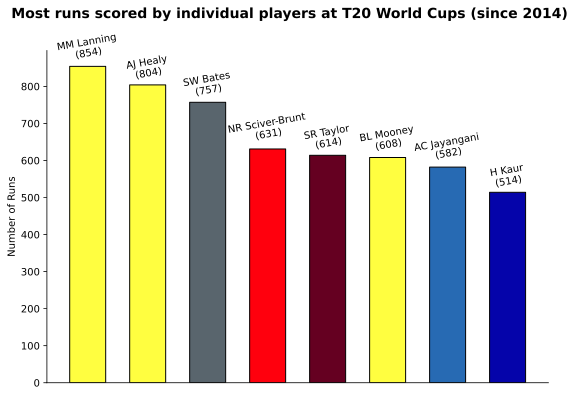

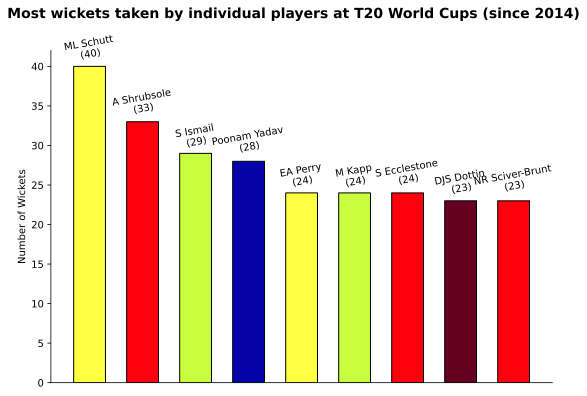

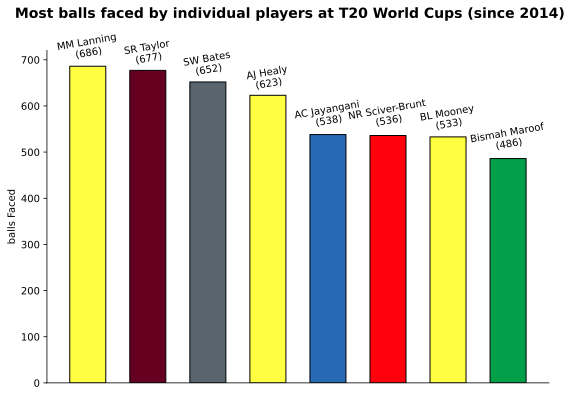

In [169]:
# most runs scored by individual players
fig2, ax2 = plt.subplots(figsize=(9, 6))
fig2.suptitle("Most runs scored by individual players at T20 World Cups (since 2014)",
              fontsize=14,fontweight='bold')
get_top_wicks_and_runs(ax2,'runs')

# most wickets taken by individual players
fig3, ax3 = plt.subplots(figsize=(9, 6))
fig3.suptitle("Most wickets taken by individual players at T20 World Cups (since 2014)",
              fontsize=14,fontweight='bold')
get_top_wicks_and_runs(ax3,'wickets')

# players who have faced the most balls 
balls_faced_by_batters = pd.DataFrame([[batter,batter_df.shape[0]] for batter,batter_df 
                                       in top_run_wicket_data.groupby('batter')],
                                       columns=['player','balls faced'])
most_balls_faced = balls_faced_by_batters.nlargest(8,
                                        'balls faced',keep='all').set_index('player')

fig4, ax4 = plt.subplots(figsize=(9,6))
fig4.suptitle("Most balls faced by individual players at T20 World Cups (since 2014)",
              fontsize=14,fontweight='bold')
make_bar_chart(ax4,most_balls_faced,"balls Faced",'balls faced')

# How runs are scored
As would be expected most balls are hits for dots, followed closely by ones, although the number of dots seems to have declined recently, hitting it's lowest percentage of 43.6% in 2023. 6s remain very rare in the womens game, hovering at about 1% of balls being hit for a 6. In contrast to this, the number of 4s hit seems to have been increasing over time, up from 9.2% in 2014 to 11.5% in 2023. 
 
We can see that the percentage of runs scored through extras has remained pretty much constant over time, at around 5.5%. It's a similar story for the percentage of balls hit to the boundary, although this has crept up by a few percent over the years. 

In [170]:
def make_runs_pie_charts(column,colours,axis,df,title,alphabetical=True):   
    """Creates and deals with the formatting for the number of runs scored per ball"""
    counts =  df[column].value_counts().sort_index(ascending=alphabetical).tolist() 
    if len(counts) != 7: counts = counts[0:5] + [0] + [counts[5]]
    (for_legend,_,texts) = axis.pie(x=counts,colors=colours,autopct=lambda p:'{:.1f}%'.format(p) if p > 0 else '',
                             wedgeprops={'edgecolor' : 'black'},radius=1.1,pctdistance=0.65,startangle=340,
                             textprops = {'color' : 'xkcd:pale blue'})
    axis.set_title(title)
    sets = [(0,0),(0,0),(0,-0.7),(0.5,-0.6),(0.1,-0.05),(0.7,-0.3),(0.7,-0.05)]
    for idx,text in enumerate(texts):
        try: 
            if float(text.get_text()[:-1]) < 20:
                (x,y) = text.get_position()
                text.set_position((x + sets[idx][0],y + sets[idx][1]))
            if idx == 2 or idx ==3:
                text.set_color('black')
                axis.annotate('', xy=(x+0.125,y-0.25), xytext=(0.9*(x + sets[idx][0]), 0.9*(y + sets[idx][1])),
                               arrowprops=dict(arrowstyle='-'))
            elif idx == 5 or idx == 6:
                text.set_color('black')
                axis.annotate('', xy=(x+0.3,y-0.15), xytext=(0.9*(x + sets[idx][0]) -0.1 , 0.9*(y + sets[idx][1])),
                               arrowprops=dict(arrowstyle='-'))
        except ValueError: pass
    return for_legend

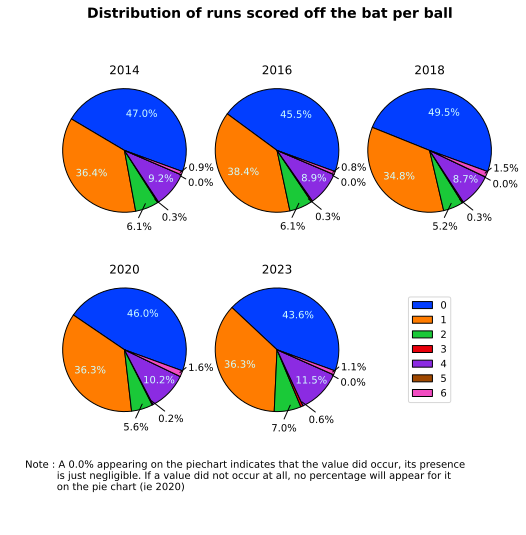

In [171]:
# 0/1/2/4/6s per tournament
years = [x for _,x in top_run_wicket_data.groupby('season')]
fig5, ax5 = plt.subplots(2,3,figsize=(8,8))
ax5 = ax5.ravel()
for ax,year,title in zip(ax5,years,YEARS):
    legend_cols = make_runs_pie_charts('runs_off_bat',DEFAULT_COLOURS,ax,year,title)
ax5[-1].set_axis_off()
ax5[-1].legend(legend_cols,np.arange(0,7),loc='center',fontsize=10)
ax5[-1].annotate(f'Note : A 0.0% appearing on the piechart indicates that the value did occur, its presence \n          is just negligible. If a value did not occur at all, no percentage will appear for it \n          on the pie chart (ie 2020)',
                xy=(25,45),xycoords='figure points')
fig5.suptitle("Distribution of runs scored off the bat per ball",fontsize=14,fontweight='bold')
fig5.subplots_adjust(bottom=0.229,top=0.886,wspace=0.086,hspace=0.117)

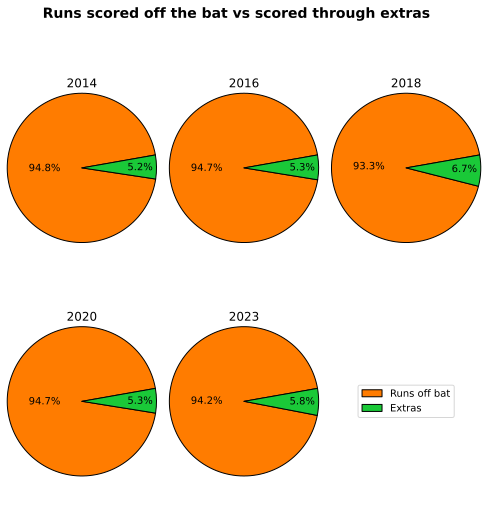

In [172]:
# runs scored off bat vs extras per tournament
extras_df = raw_data[['season','runs_off_bat','extras_off_ball']].copy()
years = [x for _,x in extras_df.groupby('season')]
fig7, axes7 = plt.subplots(2,3,figsize=(8.5,8.5))
ax7 = axes7.ravel()

for ax,year,title in zip(ax7,years,YEARS):
    counts = np.array([year['runs_off_bat'].sum(),year['extras_off_ball'].sum()])
    (for_legend,_,texts) = ax.pie(x=counts,colors=DEFAULT_COLOURS[1:3],autopct='%1.1f%%',radius=1.25,
                                  pctdistance=0.5, startangle=10,wedgeprops={'edgecolor' : 'black'},
                                  textprops={'fontsize' : 10})
    (x,y) = texts[1].get_position()
    texts[1].set_position((x+0.35,y))
    ax.set_title(title)
      

ax7[-1].set_axis_off()
ax7[-1].legend(for_legend,['Runs off bat','Extras'],loc='center',fontsize=10)
fig7.suptitle("Runs scored off the bat vs scored through extras",fontsize=14,fontweight='bold')
fig7.subplots_adjust(bottom=0.164,top=0.888,wspace=0.086,hspace=0.117)


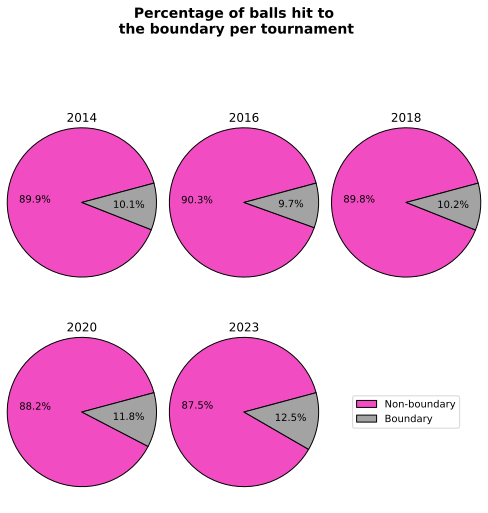

In [173]:
# percentage of balls which go for a boundary (bar chart ??)
boundary_balls_df = raw_data[['season','runs_off_bat','non_boundary']].copy()

fig8 , ax8 = plt.subplots(2,3,figsize=(8.5,8.5))
ax8 = ax8.ravel()
years = [x for _,x in boundary_balls_df.groupby('season')]

for ax,year,title in zip(ax8,years,YEARS):
    x = year['runs_off_bat'].value_counts()
    boundaries = x.loc[4] + x.loc[6] - year[~year['non_boundary'].isnull()].shape[0]
    counts = (x.sum() - boundaries, boundaries)
    (for_legend,_,_) = ax.pie(counts,colors=DEFAULT_COLOURS[6:8],autopct='%1.1f%%',radius=1.25,pctdistance=0.63,
            startangle=15,wedgeprops={'edgecolor' : 'black'},textprops={'fontsize' : 10})
    ax.set_title(title)
    
ax8[-1].set_axis_off()
ax8[-1].legend(for_legend,['Non-boundary','Boundary'],loc='center',fontsize=10)
fig8.suptitle("Percentage of balls hit to \nthe boundary per tournament",fontsize=14,fontweight='bold')
fig8.subplots_adjust(bottom=0.164,top=0.814,wspace=0.086,hspace=0.117)

# Review Success

DRS was first used in a Women's T20 World Cup in 2018, which was in fact the first ICC T20 tournament to make use of DRS. We can see that India  and Australia seem to make the most effective use of their reviews, with a nearly 50/50 success rate apiece. Other teams such as Bangladesh and Ireland are much more wasteful with them, having just a 16% and 12% success rate respectively. 

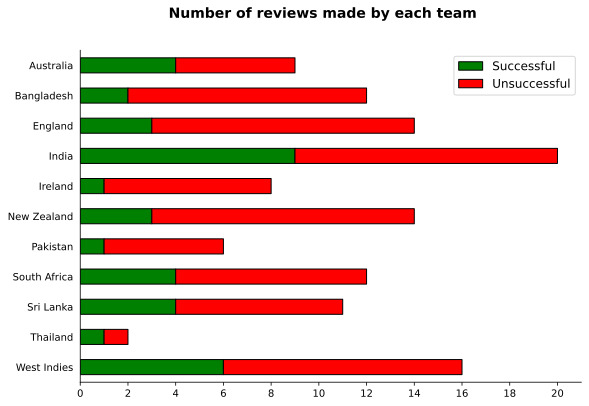

In [174]:
# success percentage of reviews per team (bar chart)
review_data = raw_data[['review_by','review_decision']].copy()
dfs = []

for team,df in review_data.groupby('review_by'):
    x = df.value_counts()
    dfs.append([team,x[team]['upheld'],x[team]['struck down']])

fig6, ax6 = plt.subplots(figsize=(9,6))
review_comp = pd.DataFrame(dfs,columns=['Team','Successful','Unsuccessful'])[::-1].set_index('Team')
review_comp.plot(kind='barh',stacked=True,ax=ax6,color=['green','red'],edgecolor='black')

fig6.suptitle("Number of reviews made by each team",fontsize=14,fontweight='bold')
ax6.legend(loc='upper right',fontsize = 12)
ax6.set_xticks(np.arange(0,22,2))
ax6.tick_params(axis='y',width = 0)
ax6.set_ylabel('')
ax6.spines[['right', 'top']].set_visible(False)

# Innings comparison
Finally we take a look at the difference between the first and second innings across all tournaments. We can see that nearly all teams lasted the entirety of the first innings, with a lot of matches having a few no balls, pushing the total number of balls bowled to between 122-126. This is further seen in that only 9 first innings matches had 10 wickets taken. Instead first innings generally saw between 5 and 8 wickets taken, with not many games at the extremes of 0/1 or 9/10 wickets. 

The second innings tends to be much different, with far fewer matches making it to/past 120 balls. Far more games resulted in a team being bowled out, with over 20 matches having 10 wickets taken. There was even a couple of games having only 50/60 balls bowled before the total was either caught, or the team was bowled out. The numbers of wickets taken tend to sit at the extremes, having most matches end up with 9/10 wickets taken, or only 0/1/2.

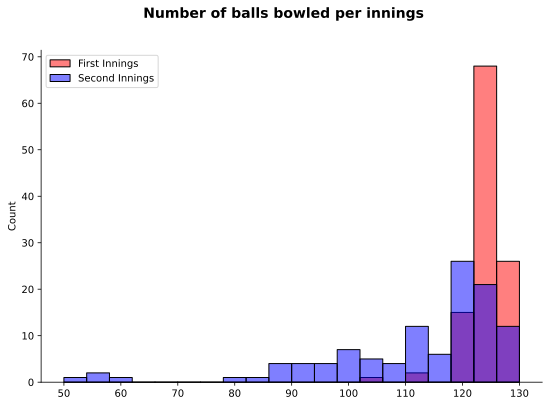

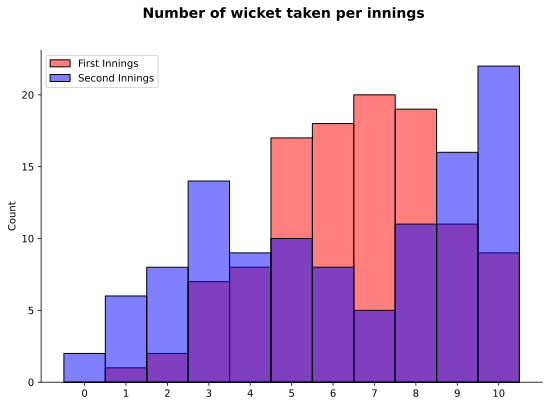

In [175]:
# number of balls per innings 
num_ball_df = raw_data[['season','RecNo','player_out']].copy()
num_ball_df['first innings'] = num_ball_df['RecNo'].str[2] == 'a'
num_balls = [[df.shape[0] for _,df in x.groupby('RecNo')] for _,x in num_ball_df.groupby('first innings')]

fig9 , ax9 = plt.subplots(figsize=(9, 6))
sns.histplot(num_balls,ax=ax9,binwidth=4,palette=['blue','red'])
ax9.spines[['right', 'top']].set_visible(False)
fig9.suptitle("Number of balls bowled per innings",fontsize=14,fontweight='bold')
ax9.legend(loc='upper left',labels=['First Innings','Second Innings'])

# average wickets taken per innings per tournament
num_out = [[df['player_out'].count()-0.5 for r,df in x.groupby('RecNo')] for _,x in
            num_ball_df.groupby('first innings')]
fig10 , ax10 = plt.subplots(figsize=(9, 6))
sns.histplot(num_out,ax=ax10,binwidth=1,palette=['blue','red'])
fig10.suptitle("Number of wicket taken per innings",fontsize=14,fontweight='bold')
ax10.set_xticks(np.arange(0,11,1))
ax10.legend(labels=['First Innings','Second Innings'])
ax10.spines[['right', 'top']].set_visible(False)

Thank you very much for checking out this notebook🙏. Any feedback (both positive and negative) would be much appreciated.

Feel free to check out the dataset this is based on from : https://www.kaggle.com/datasets/acidbear55/icc-womens-t20-world-cups-2014-2023/data